In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d msambare/fer2013

 76% 46.0M/60.3M [00:00<00:00, 94.9MB/s]
100% 60.3M/60.3M [00:00<00:00, 114MB/s] 


In [ ]:
!unzip fer2013.zip

In [19]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Dense, Flatten, GlobalAveragePooling2D
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.applications.resnet50 import ResNet50
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [5]:
def input_data(folder_path, output_data):
  for dirs in os.listdir(folder_path):
    class_name = dirs
    new_path = os.path.join(folder_path, class_name)
    for img in os.listdir(new_path):
      img_arr = cv.imread(os.path.join(new_path, img))
      output_data.append([img_arr, class_name])
  return output_data

In [6]:
train_data = input_data("/content/train", [])

In [7]:
test_data = input_data("/content/test", [])

In [8]:
np.random.shuffle(train_data)
np.random.shuffle(test_data)

In [9]:
train_images = []
train_labels = []
for features, labels in train_data:
  train_images.append(features)
  train_labels.append(labels)

In [10]:
test_images = []
test_labels = []
for features, labels in test_data:
  test_images.append(features)
  test_labels.append(labels)

In [11]:
label_enc = LabelEncoder()
train_labels = label_enc.fit_transform(train_labels)
test_labels = label_enc.transform(test_labels)

In [12]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [13]:
print(f"Shape of the train images {train_images.shape}")
print(f"Shape of the train labels {train_labels.shape}")
print(f"Shape of the test images {test_images.shape}")
print(f"Shape of the test labels {test_labels.shape}")

Shape of the train images (28709, 48, 48, 3)
Shape of the train labels (28709,)
Shape of the test images (7178, 48, 48, 3)
Shape of the test labels (7178,)


In [14]:
train_images = train_images/255
test_images = test_images/255

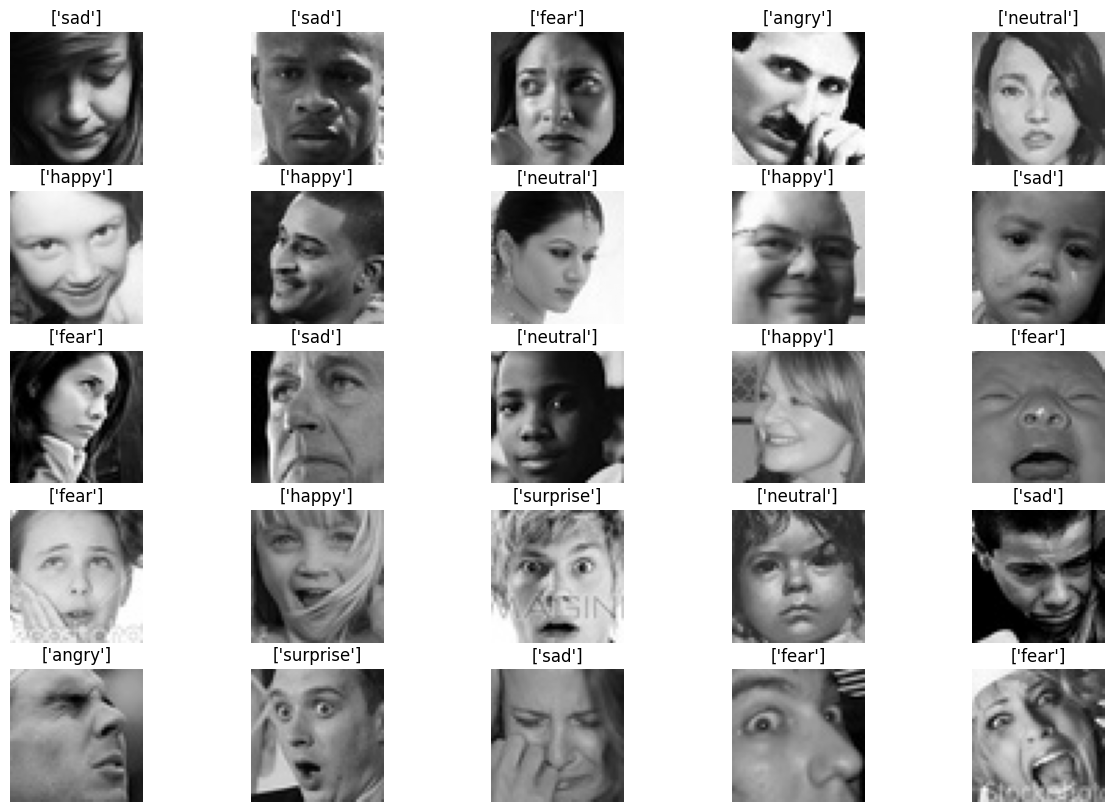

In [17]:
plt.figure(figsize=(15,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(test_images[i])
  plt.title(f"{label_enc.inverse_transform([test_labels[i]])}")
  plt.axis("off")

**CNN Model** 

In [26]:
model1 = Sequential()

In [27]:
model1.add(Conv2D(32, (3, 3), input_shape=(48,48,3), activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(64, (3, 3), activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(128, (3, 3), activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(256, (3, 3), activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Flatten())
model1.add(Dense(512, activation="relu"))
model1.add(Dense(7, activation="softmax"))

In [54]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 4, 4, 128)       

In [28]:
model1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

In [29]:
history1 = model1.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=30)

Epoch 1/30
898/898 [==============================] - 9s 8ms/step - loss: 1.6083 - accuracy: 0.3585 - val_loss: 1.3817 - val_accuracy: 0.4709
Epoch 2/30
898/898 [==============================] - 5s 6ms/step - loss: 1.2594 - accuracy: 0.5186 - val_loss: 1.2106 - val_accuracy: 0.5404
Epoch 3/30
898/898 [==============================] - 6s 6ms/step - loss: 1.0990 - accuracy: 0.5833 - val_loss: 1.1550 - val_accuracy: 0.5626
Epoch 4/30
898/898 [==============================] - 5s 6ms/step - loss: 0.9530 - accuracy: 0.6392 - val_loss: 1.1733 - val_accuracy: 0.5639
Epoch 5/30
898/898 [==============================] - 6s 6ms/step - loss: 0.7959 - accuracy: 0.7029 - val_loss: 1.2274 - val_accuracy: 0.5766
Epoch 6/30
898/898 [==============================] - 5s 6ms/step - loss: 0.6272 - accuracy: 0.7686 - val_loss: 1.2931 - val_accuracy: 0.5812
Epoch 7/30
898/898 [==============================] - 6s 6ms/step - loss: 0.4681 - accuracy: 0.8288 - val_loss: 1.4943 - val_accuracy: 0.5724
Epoch 

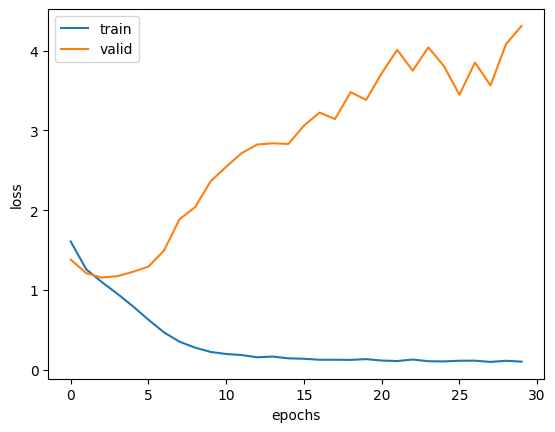

In [31]:
plt.plot(history1.history["loss"])
plt.plot(history1.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["train","valid"])

In [32]:
y_pred1 = model1.predict(test_images)

225/225 [==============================] - 1s 2ms/step


In [33]:
print(classification_report(y_pred1.argmax(axis=1), test_labels))

              precision    recall  f1-score   support

           0       0.52      0.44      0.48      1139
           1       0.49      0.64      0.55        85
           2       0.41      0.42      0.41      1021
           3       0.78      0.75      0.76      1836
           4       0.50      0.53      0.52      1166
           5       0.44      0.46      0.45      1181
           6       0.70      0.78      0.74       750

    accuracy                           0.57      7178
   macro avg       0.55      0.57      0.56      7178
weighted avg       0.57      0.57      0.57      7178



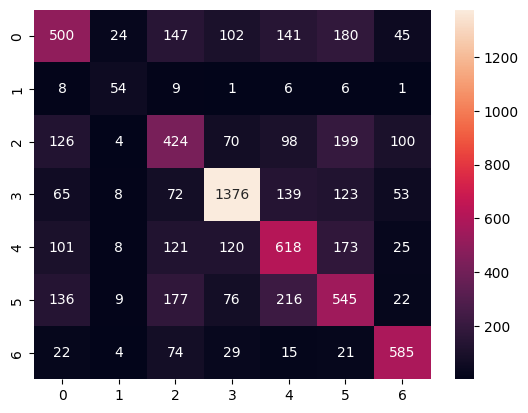

In [37]:
sns.heatmap(confusion_matrix(y_pred1.argmax(axis=1), test_labels), fmt='g', annot=True)
plt.show()

**CNN Model with Dropout, Global Average Pooling2D and  BatchNormalization layer**

In [38]:
model2 = Sequential()

In [39]:
model2.add(Conv2D(32, (3, 3), input_shape=(48,48,3), activation="leaky_relu"))
model2.add(BatchNormalization())
model2.add(Dropout(0.1))
model2.add(MaxPool2D(2,2))
model2.add(Conv2D(64, (3, 3), activation="leaky_relu"))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(MaxPool2D(2,2))
model2.add(Conv2D(128, (3, 3), activation="leaky_relu"))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(MaxPool2D(2,2))
model2.add(Conv2D(256, (3, 3), activation="leaky_relu"))
model2.add(MaxPool2D(2,2))
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dense(512, activation="relu"))
model2.add(BatchNormalization())
model2.add(Dense(7, activation="softmax"))

In [55]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 64)      

In [40]:
model2.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [41]:
history2 = model2.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=30)

Epoch 1/30
898/898 [==============================] - 14s 10ms/step - loss: 1.6135 - accuracy: 0.3894 - val_loss: 1.5822 - val_accuracy: 0.4030
Epoch 2/30
898/898 [==============================] - 9s 10ms/step - loss: 1.3493 - accuracy: 0.4911 - val_loss: 1.3644 - val_accuracy: 0.4674
Epoch 3/30
898/898 [==============================] - 9s 10ms/step - loss: 1.2384 - accuracy: 0.5365 - val_loss: 1.4760 - val_accuracy: 0.4695
Epoch 4/30
898/898 [==============================] - 8s 9ms/step - loss: 1.1588 - accuracy: 0.5645 - val_loss: 1.3102 - val_accuracy: 0.5163
Epoch 5/30
898/898 [==============================] - 9s 11ms/step - loss: 1.0906 - accuracy: 0.5911 - val_loss: 1.4555 - val_accuracy: 0.4503
Epoch 6/30
898/898 [==============================] - 9s 10ms/step - loss: 1.0224 - accuracy: 0.6156 - val_loss: 1.3114 - val_accuracy: 0.5109
Epoch 7/30
898/898 [==============================] - 9s 9ms/step - loss: 0.9615 - accuracy: 0.6385 - val_loss: 1.1964 - val_accuracy: 0.5620


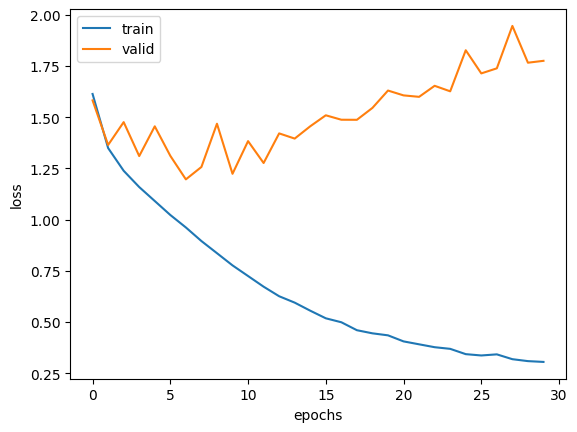

In [42]:
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["train","valid"])

In [43]:
y_pred2 = model2.predict(test_images)

225/225 [==============================] - 1s 4ms/step


In [44]:
print(classification_report(y_pred2.argmax(axis=1), test_labels))

              precision    recall  f1-score   support

           0       0.50      0.52      0.51       920
           1       0.57      0.56      0.56       113
           2       0.46      0.41      0.44      1150
           3       0.73      0.86      0.79      1507
           4       0.55      0.54      0.54      1249
           5       0.53      0.44      0.48      1521
           6       0.70      0.81      0.75       718

    accuracy                           0.59      7178
   macro avg       0.58      0.59      0.58      7178
weighted avg       0.58      0.59      0.58      7178



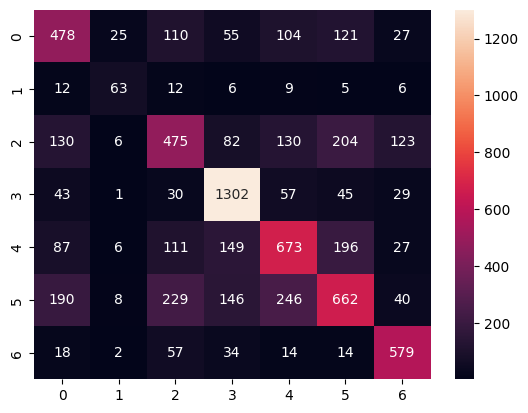

In [45]:
sns.heatmap(confusion_matrix(y_pred2.argmax(axis=1), test_labels), fmt='g', annot=True)
plt.show()

**CNN Model with Dropout and GlobalAveragePooling2D layer**

In [62]:
model3 = Sequential()

In [63]:
model3.add(Conv2D(32, (3, 3), input_shape=(48,48,3), activation="leaky_relu", padding="same"))
model3.add(Conv2D(32, (3, 3),activation="leaky_relu", padding="same"))
model3.add(Dropout(0.1))
model3.add(MaxPool2D(2,2))
model3.add(Conv2D(64, (3, 3), activation="leaky_relu", padding="same"))
model3.add(Dropout(0.2))
model3.add(MaxPool2D(2,2))
model3.add(Conv2D(128, (3, 3), activation="leaky_relu", padding="same"))
model3.add(Dropout(0.3))
model3.add(MaxPool2D(2,2))
model3.add(Conv2D(256, (3, 3), activation="leaky_relu", padding="same"))
model3.add(MaxPool2D(2,2))
model3.add(Dropout(0.3))
model3.add(GlobalAveragePooling2D())
model3.add(Dense(512, activation="relu"))
model3.add(Dense(7, activation="softmax"))

In [64]:
model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 conv2d_43 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 dropout_17 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 dropout_18 (Dropout)        (None, 24, 24, 64)        0         
                                                      

In [65]:
model3.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [66]:
history3 = model3.fit(train_images, train_labels, validation_data = (test_images, test_labels), epochs=30)

Epoch 1/30
898/898 [==============================] - 14s 12ms/step - loss: 1.7980 - accuracy: 0.2588 - val_loss: 1.7406 - val_accuracy: 0.2856
Epoch 2/30
898/898 [==============================] - 9s 10ms/step - loss: 1.5542 - accuracy: 0.3918 - val_loss: 1.4392 - val_accuracy: 0.4570
Epoch 3/30
898/898 [==============================] - 10s 11ms/step - loss: 1.3331 - accuracy: 0.4868 - val_loss: 1.3010 - val_accuracy: 0.5001
Epoch 4/30
898/898 [==============================] - 9s 10ms/step - loss: 1.2165 - accuracy: 0.5331 - val_loss: 1.2635 - val_accuracy: 0.5293
Epoch 5/30
898/898 [==============================] - 10s 11ms/step - loss: 1.1348 - accuracy: 0.5624 - val_loss: 1.2208 - val_accuracy: 0.5412
Epoch 6/30
898/898 [==============================] - 9s 10ms/step - loss: 1.0856 - accuracy: 0.5869 - val_loss: 1.3450 - val_accuracy: 0.5287
Epoch 7/30
898/898 [==============================] - 10s 11ms/step - loss: 1.0335 - accuracy: 0.6034 - val_loss: 1.1944 - val_accuracy: 0.

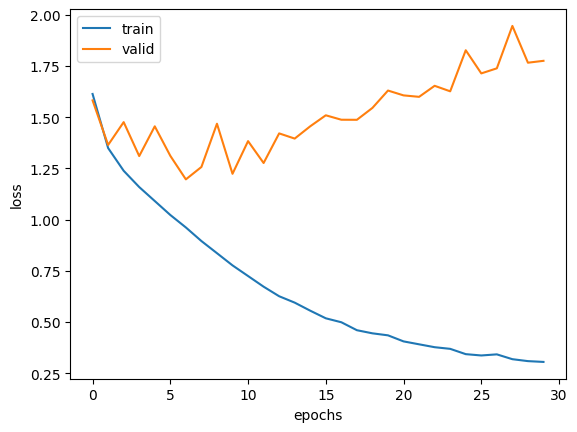

In [68]:
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["train","valid"])

In [67]:
y_pred3 = model3.predict(test_images)

225/225 [==============================] - 1s 4ms/step


In [69]:
print(classification_report(y_pred3.argmax(axis=1), test_labels))

              precision    recall  f1-score   support

           0       0.55      0.48      0.52      1090
           1       0.57      0.48      0.52       131
           2       0.46      0.46      0.46      1019
           3       0.81      0.82      0.81      1758
           4       0.50      0.61      0.55      1005
           5       0.51      0.47      0.49      1357
           6       0.76      0.77      0.77       818

    accuracy                           0.61      7178
   macro avg       0.59      0.59      0.59      7178
weighted avg       0.61      0.61      0.61      7178



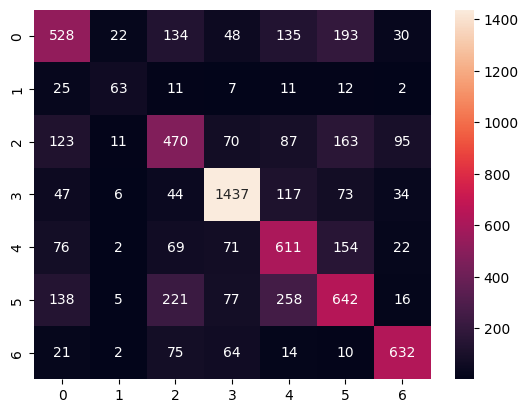

In [70]:
sns.heatmap(confusion_matrix(y_pred3.argmax(axis=1), test_labels), fmt='g', annot=True)
plt.show()